# An unsupervised learning method (clustering): DBSCAN

In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import warnings
import matplotlib.pyplot as plt
from itertools import islice, cycle
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, rand_score, normalized_mutual_info_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns

## Comparison of DBSCAN to other clustering methods

### Generate the synthetic datasets

In [ ]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(
    n_samples=n_samples, noise=0.05, random_state=seed
)
random_state = 170
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

### Make predictions and plot the datasets

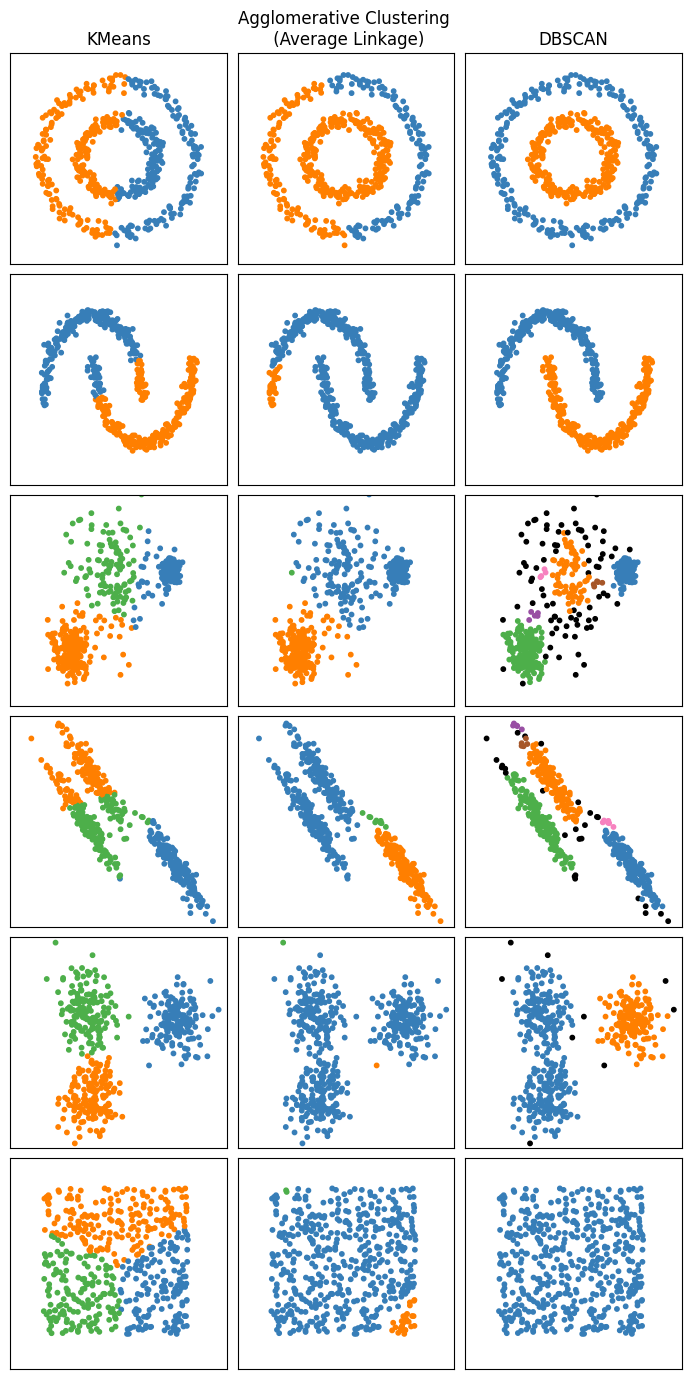

In [ ]:
plot_num = 1

plt.figure(figsize=(7, 14))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.01, top=0.95, wspace=0.05, hspace=0.05
)

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    X = StandardScaler().fit_transform(X)

    kmeans = KMeans(
        n_clusters=params["n_clusters"],
        n_init="auto",
        random_state=params["random_state"],
    )

    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    connectivity = 0.5 * (connectivity + connectivity.T)
    average_linkage = AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )

    dbscan = DBSCAN(eps=params["eps"])

    clustering_algorithms = (
        ("KMeans", kmeans),
        ("Agglomerative Clustering \n (Average Linkage)", average_linkage),
        ("DBSCAN", dbscan),
    )

    for name, algorithm in clustering_algorithms:
      with warnings.catch_warnings():
          warnings.filterwarnings(
              "ignore",
              message="the number of connected components of the "
              + "connectivity matrix is [0-9]{1,2}"
              + " > 1. Completing it to avoid stopping the tree early.",
              category=UserWarning,
          )
          warnings.filterwarnings(
              "ignore",
              message="Graph is not fully connected, spectral embedding"
              + " may not work as expected.",
              category=UserWarning,
          )
          algorithm.fit(X)

      if hasattr(algorithm, "labels_"):
          y_pred = algorithm.labels_.astype(int)
      else:
          y_pred = algorithm.predict(X)

      plt.subplot(len(datasets), len(clustering_algorithms), plot_num)

      if i_dataset == 0:
          plt.title(name, size=12)

      colors = np.array(
          list(
              islice(
                  cycle(
                      [
                          "#377eb8",
                          "#ff7f00",
                          "#4daf4a",
                          "#f781bf",
                          "#a65628",
                          "#984ea3",
                          "#999999",
                          "#e41a1c",
                          "#dede00",
                      ]
                  ),
                  int(max(y_pred) + 1),
              )
          )
      )

      colors = np.append(colors, ["#000000"])

      plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
      plt.xlim(-2.5, 2.5)
      plt.ylim(-2.5, 2.5)
      plt.xticks(())
      plt.yticks(())

      plot_num += 1

plt.show()

## The working mechanism of DBSCAN

See the slides.

## Evaluation metrics for clustering

See the slides.

## Applications of the DBSCAN

### Iris dataset

The dataset was taken from: https://www.kaggle.com/datasets/uciml/iris.

In [ ]:
iris_df = pd.read_csv('Iris.csv')

iris_df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [ ]:
iris_df = iris_df.drop('Id', axis=1)
y_iris = iris_df.pop('Species')
label_names = set(y_iris)
X_iris = iris_df
enc = LabelEncoder()
y_iris = enc.fit_transform(y_iris)

print("Label names:", label_names)
print("Labels:\n", y_iris)

Label names: {'Iris-versicolor', 'Iris-virginica', 'Iris-setosa'}
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [ ]:
def split_dataset_and_get_labels(clustering_algorithm, X):
  ca = clustering_algorithm.fit(X)

  y_predict = ca.labels_

  print("Labels:\n", y_predict)
  print()

  return y_predict

In [ ]:
y_predict_kmeans = split_dataset_and_get_labels(KMeans(n_clusters=3, n_init='auto'), X_iris)
y_predict_dbscan = split_dataset_and_get_labels(DBSCAN(), X_iris)

Labels:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]

Labels:
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1 -1 -1  1
  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]



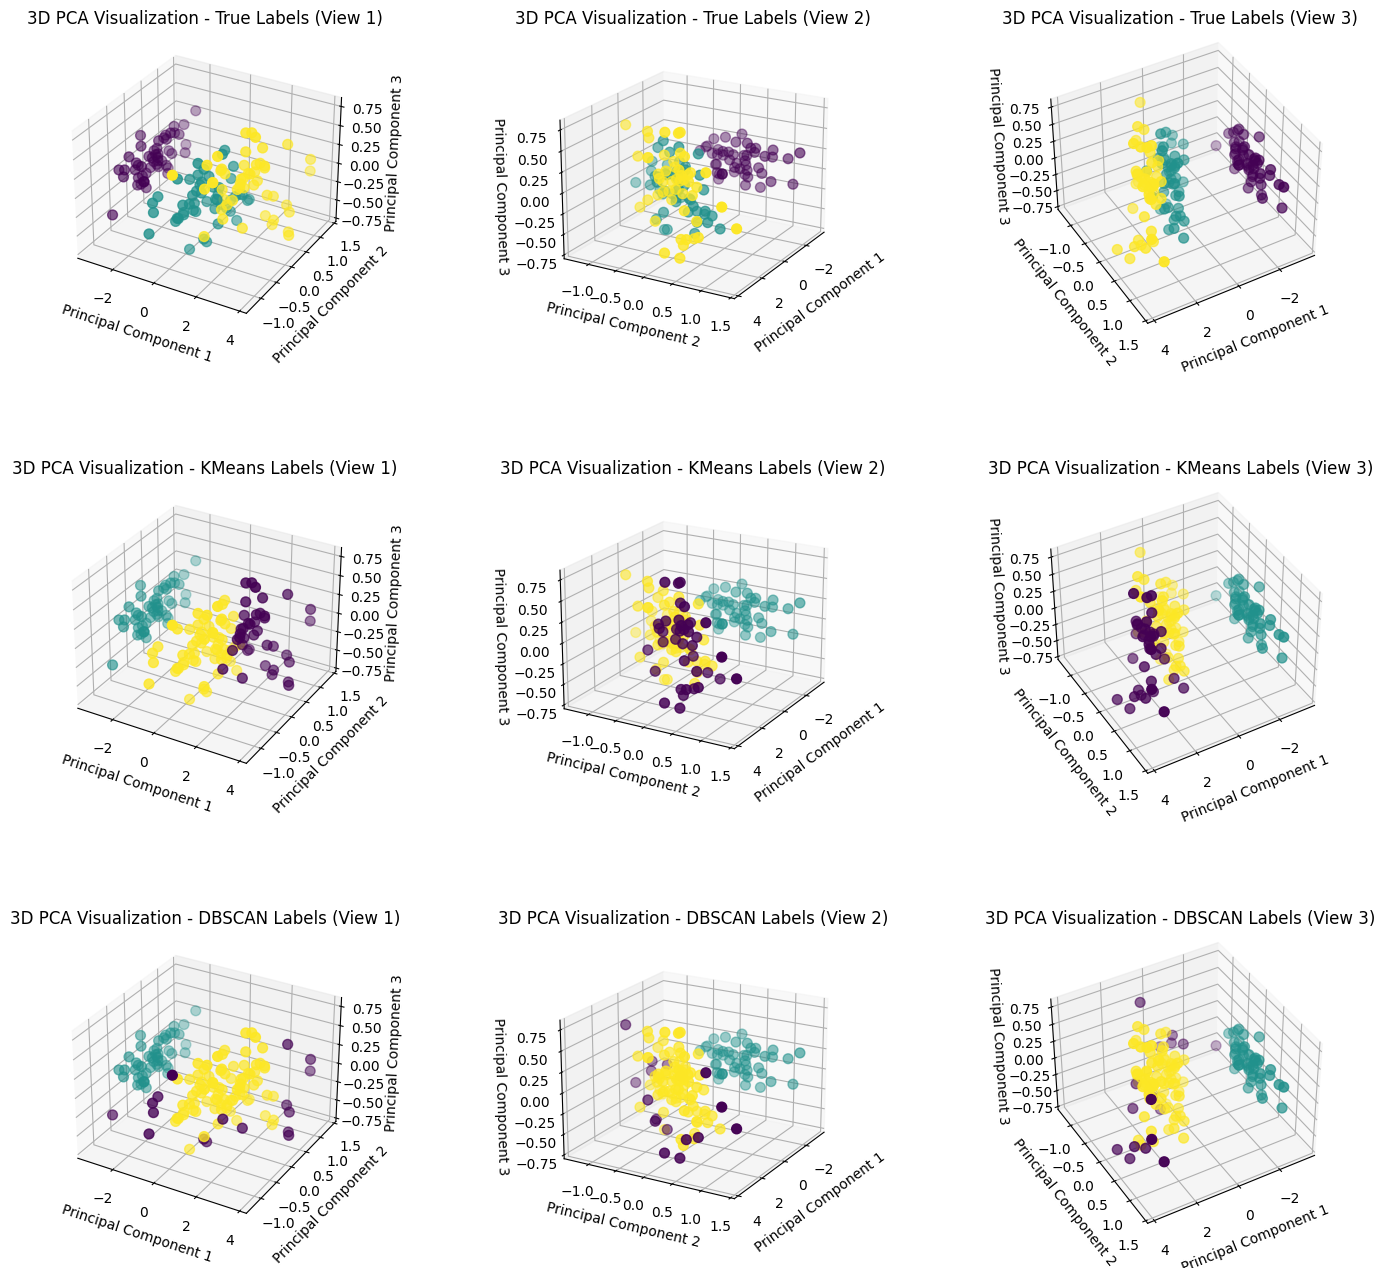

In [ ]:
def plot_one_subplot(
    grid_and_position,
    fig,
    algorithm_name,
    view_nr,
    df_pca,
    elevation=None,
    azimuth=None
):
  ax = fig.add_subplot(grid_and_position, projection='3d')
  ax.set_title(
      f"3D PCA Visualization - {algorithm_name} Labels (View {view_nr})"
  )
  ax.scatter(
      df_pca["Principal Component 1"],
      df_pca["Principal Component 2"],
      df_pca["Principal Component 3"],
      c=df_pca['Target'],
      s=50
  )
  ax.set_xlabel("Principal Component 1")
  ax.set_ylabel("Principal Component 2")
  ax.set_zlabel("Principal Component 3")

  if elevation is not None and azimuth is not None:
    ax.view_init(elev=elevation, azim=azimuth)

def plot_all_algorithm_predictions():
  pca = PCA(n_components=3)
  X_pca = pca.fit_transform(X_iris)

  fig = plt.figure(figsize=(15, 15))

  df_pca = pd.DataFrame(data=X_pca, columns=[
      "Principal Component 1",
      "Principal Component 2",
      "Principal Component 3"
  ])
  df_pca['Target'] = y_iris
  algorithm_name = 'True'

  plot_one_subplot(331, fig, algorithm_name, 1, df_pca)
  plot_one_subplot(332, fig, algorithm_name, 2, df_pca, 20, 30)
  plot_one_subplot(333, fig, algorithm_name, 3, df_pca, 40, 60)

  df_pca['Target'] = y_predict_kmeans
  algorithm_name = 'KMeans'

  plot_one_subplot(334, fig, algorithm_name, 1, df_pca)
  plot_one_subplot(335, fig, algorithm_name, 2, df_pca, 20, 30)
  plot_one_subplot(336, fig, algorithm_name, 3, df_pca, 40, 60)

  df_pca['Target'] = y_predict_dbscan
  algorithm_name = 'DBSCAN'

  plot_one_subplot(337, fig, algorithm_name, 1, df_pca)
  plot_one_subplot(338, fig, algorithm_name, 2, df_pca, 20, 30)
  plot_one_subplot(339, fig, algorithm_name, 3, df_pca, 40, 60)

  plt.subplots_adjust(
      left=0.05,
      right=0.95,
      top=0.9,
      bottom=0.1,
      wspace=0.3,
      hspace=0.5
  )

plot_all_algorithm_predictions()

plt.show()

In [ ]:
def evaluate_clustering_algorithm(dataset_name, algorithm_name, X, y, y_predict):
  print(f"{dataset_name} with {algorithm_name}:")

  if y is not None:
    ri = rand_score(y, y_predict)
    nmi = normalized_mutual_info_score(y, y_predict)

    print(f"Rand Index (0 -> 1): {ri:.2f}")
    print(f"Normalized Mutual Information (0 -> 1): {nmi:.2f}")

  sil = silhouette_score(X, y_predict)
  ch = calinski_harabasz_score(X, y_predict)

  print(f"Silhouette Score (-1 -> 1): {sil:.2f}")
  print(f"Calinski-Harabasz Index (relative, the higher the better): {ch:.2f}")
  print()

In [ ]:
evaluate_clustering_algorithm('Iris', 'KMeans', X_iris, y_iris, y_predict_kmeans)
evaluate_clustering_algorithm('Iris', 'DBSCAN', X_iris, y_iris, y_predict_dbscan)

Iris with KMeans:
Rand Index (0 -> 1): 0.87
Normalized Mutual Information (0 -> 1): 0.74
Silhouette Score (-1 -> 1): 0.55
Calinski-Harabasz Index (relative, the higher the better): 560.37

Iris with DBSCAN:
Rand Index (0 -> 1): 0.77
Normalized Mutual Information (0 -> 1): 0.60
Silhouette Score (-1 -> 1): 0.49
Calinski-Harabasz Index (relative, the higher the better): 219.87



### Cell dataset

The dataset was taken from: https://reneshbedre.github.io/assets/posts/tsne/tsne_scores.csv.

In [ ]:
X_cell = pd.read_csv("https://reneshbedre.github.io/assets/posts/tsne/tsne_scores.csv")

X_cell

,t-SNE-1,t-SNE-2
0,10.846841,-16.712580
1,24.794334,-16.775398
2,2.953309,13.379048
3,27.262146,-31.886690
4,-23.015728,64.468376
...,...,...
4401,-15.211057,-69.717155
4402,-9.403443,-62.847458
4403,-17.546083,-10.295582
4404,-8.512799,16.375420


In [ ]:
y_predict_kmeans_cell = split_dataset_and_get_labels(KMeans(n_clusters=10, n_init='auto'), X_cell)
y_predict_dbscan_cell = split_dataset_and_get_labels(DBSCAN(eps = 4.54, min_samples = 4), X_cell)

Labels:
 [1 1 5 ... 2 5 2]

Labels:
 [0 0 1 ... 1 1 1]



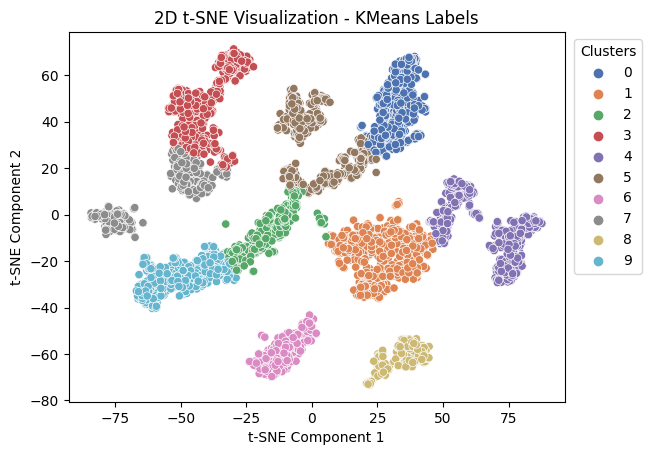

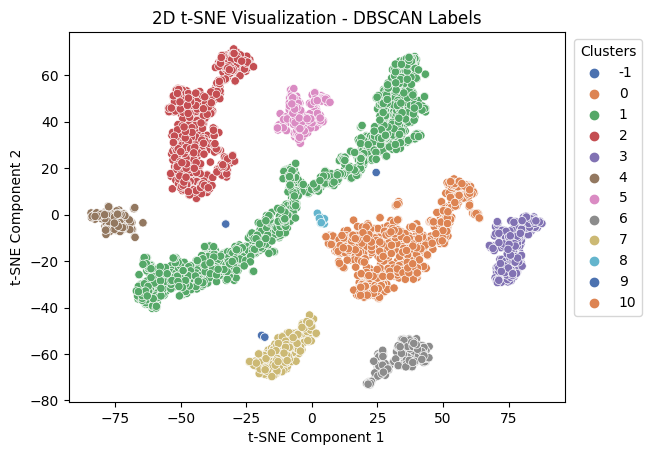

In [ ]:
def plot_with_legend(algorithm_name, X, y_predict):
  ax = sns.scatterplot(
      data=X,
      x='t-SNE-1',
      y='t-SNE-2',
      hue=y_predict,
      legend='full',
      palette='deep'
  )

  ax.set(title=f"2D t-SNE Visualization - {algorithm_name} Labels")
  ax.set_xlabel('t-SNE Component 1')
  ax.set_ylabel('t-SNE Component 2')

  sns.move_legend(
      ax,
      "upper right",
      bbox_to_anchor=(1.17, 1.),
      title='Clusters'
  )

  plt.show()

plot_with_legend('KMeans', X_cell, y_predict_kmeans_cell)
plot_with_legend('DBSCAN', X_cell, y_predict_dbscan_cell)

In [ ]:
evaluate_clustering_algorithm('Cell', 'KMeans', X_cell, None, y_predict_kmeans_cell)
evaluate_clustering_algorithm('Cell', 'DBSCAN', X_cell, None, y_predict_dbscan_cell)

Cell with KMeans:
Silhouette Score (-1 -> 1): 0.51
Calinski-Harabasz Index (relative, the higher the better): 6626.25

Cell with DBSCAN:
Silhouette Score (-1 -> 1): 0.07
Calinski-Harabasz Index (relative, the higher the better): 908.47

